Tentative de parser les fichiers du type: ProgV51-002-1.txt

In [1]:
import pandas as pd
from pathlib import Path

def parse_file(filename:str)-> pd.DataFrame:
    """
    Given the name of experiement file, 
    parse some of it into a dataframe.

    """
    p = Path(filename)
    # Files appear to be utf-16, read as binary and decode as such
    data = p.read_bytes().decode('utf-16')
    lines = data.splitlines()
    acc = []
    collect = False

    # we'll loop through the lines, it looks liek each eperiment start after as 
    # '\t*** LogFrame Start', and ends before a '\t*** LogFrame End ***'
    # we look for those, and in between split the line on colons (:), 
    # assume the left hand side is a Key, and the right ahnd side a value.
    # we collect those in a dict, and at each Frame end, push that into a list. 
    for line in lines:
        if '\t*** LogFrame Start' in line:
            collect = True
            record = {}
            continue
        elif '\t*** LogFrame End ***' in line:
            acc.append(record)
            collect = False
        if not collect:
            continue
        k,v = line.strip().split(':', maxsplit=1)
        if 'LettreListeExp' in k:
            # One of the key have a name that change each time. 
            # split LettreListeExp38 into LettreListeExpN, and N=38
            k,n = 'LettreListeExp', k[len('LettreListeExp'):] 
            record[k+'N'] = n
            record[k] = v.strip()
        else:
            record[k] = v.strip()
    df =  pd.DataFrame(acc)
    # here we will look at each column and try to make it a
    # number instead of a string.
    for c in df.columns:
        try:
            df[c] = df[c].astype(float)
        except ValueError:
            pass
    return df

df = parse_file('ProgV51-002-1.txt')
df.head()        
        

,Train,Procedure,L1,L2,L3,L4,Rep,LettreListe1,FamLettre1,Train.Cycle,...,Stimulus1.DEVICE,Stimulus1.OnsetDelay,Stimulus1.OnsetTime,Stimulus1.DurationError,Stimulus1.RTTime,Stimulus1.ACC,Stimulus1.RT,Stimulus1.RESP,Stimulus1.CRESP,Stimulus1.OnsetToOnsetTime
0,1.0,TrainProc,rond.png,triangle.png,rectangle.png,lettre_familiarisation_A_coV1.png,L4,4.0,rond.png,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,TrainProc,lettre_familiarisation_T_mv.png,barre_horiz.png,triangle.png,lettre_familiarisation_T_co.png,L4,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,TrainProc,lettre_familiarisation_R_mh_enplus.png,lettre_familiarisation_R_mh.png,lettre_familiarisation_R_mv.png,lettre_familiarisation_R_co.png,L4,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,ExpProc,4_lettres_segmentee/o_enmoins_mh.png,3_miroir_vertical/o_mv.png,2_miroir_horizontal/o_mh.png,1_liste_correcte/o_co.png,L3,NaN,NaN,NaN,...,Mouse,17.0,29825.0,-999999.0,31204.0,0.0,1379.0,1.0,,0.0
4,NaN,ExpProc,3_miroir_vertical/a_mv.png,4_lettres_segmentee/a_enmoins_sr.png,1_liste_correcte/a_co.png,2_miroir_horizontal/a_mh.png,L3,NaN,NaN,NaN,...,Mouse,16.0,31758.0,-999999.0,32473.0,0.0,715.0,1.0,,0.0


It looks like we have 3 frames were we train the user, and then we test. 

Split into 2 dataframes: the train and test dataframes.

Each of these dataframes have different column names : Stimulus.XXX and Stimulus1.XXX
After we split we remove columns that have NaNs. We'll also drop some columns that do not seem to contain any useful informations for now,


In [2]:
df_train = df[df.Procedure == 'TrainProc'].dropna(axis='columns').drop(columns=['Procedure', 'Running', 'Stimulus.DEVICE','Stimulus.DurationError','Stimulus.CRESP'])
df_exp = df[df.Procedure == 'ExpProc'].dropna(axis='columns').drop(columns=['Procedure', 'Running', 'Stimulus1.DEVICE','Stimulus1.DurationError','Stimulus1.CRESP'])

In [3]:
df_train

,Train,L1,L2,L3,L4,Rep,Train.Cycle,Train.Sample,Stimulus.OnsetDelay,Stimulus.OnsetTime,Stimulus.RTTime,Stimulus.ACC,Stimulus.RT,Stimulus.RESP,Stimulus.OnsetToOnsetTime
0,1.0,rond.png,triangle.png,rectangle.png,lettre_familiarisation_A_coV1.png,L4,1.0,1.0,17.0,19976.0,22555.0,0.0,2579.0,1.0,0.0
1,2.0,lettre_familiarisation_T_mv.png,barre_horiz.png,triangle.png,lettre_familiarisation_T_co.png,L4,1.0,2.0,16.0,23109.0,24675.0,0.0,1566.0,1.0,0.0
2,3.0,lettre_familiarisation_R_mh_enplus.png,lettre_familiarisation_R_mh.png,lettre_familiarisation_R_mv.png,lettre_familiarisation_R_co.png,L4,1.0,3.0,17.0,25226.0,27210.0,0.0,1984.0,1.0,0.0


In [4]:
df_exp

,L1,L2,L3,L4,Rep,Exp,ExpLettre1,LettreListeExpN,LettreListeExp,Exp.Cycle,Exp.Sample,Stimulus1.OnsetDelay,Stimulus1.OnsetTime,Stimulus1.RTTime,Stimulus1.ACC,Stimulus1.RT,Stimulus1.RESP,Stimulus1.OnsetToOnsetTime
3,4_lettres_segmentee/o_enmoins_mh.png,3_miroir_vertical/o_mv.png,2_miroir_horizontal/o_mh.png,1_liste_correcte/o_co.png,L3,15.0,4_lettres_segmentee/o_enmoins_mh.png,15.0,4.0,1.0,1.0,17.0,29825.0,31204.0,0.0,1379.0,1.0,0.0
4,3_miroir_vertical/a_mv.png,4_lettres_segmentee/a_enmoins_sr.png,1_liste_correcte/a_co.png,2_miroir_horizontal/a_mh.png,L3,1.0,3_miroir_vertical/a_mv.png,1.0,3.0,1.0,2.0,16.0,31758.0,32473.0,0.0,715.0,1.0,0.0
5,1_liste_correcte/f_co.png,2_miroir_horizontal/f_mh.png,4_lettres_segmentee/f_enmoins_sr.png,3_miroir_vertical/f_mv.png,L3,6.0,1_liste_correcte/f_co.png,6.0,1.0,1.0,3.0,17.0,33025.0,33794.0,0.0,769.0,1.0,0.0
6,3_miroir_vertical/u_mv.png,2_miroir_horizontal/u_mh.png,1_liste_correcte/u_co.png,4_lettres_segmentee/u_enplus_mv.png,L3,21.0,3_miroir_vertical/u_mv.png,21.0,3.0,1.0,4.0,16.0,34358.0,35119.0,0.0,761.0,1.0,0.0
7,2_miroir_horizontal/y_mh.png,4_lettres_segmentee/y_enmoins_mv.png,1_liste_correcte/y_co.png,3_miroir_vertical/y_mv.png,L3,25.0,2_miroir_horizontal/y_mh.png,25.0,2.0,1.0,5.0,17.0,35675.0,36486.0,0.0,811.0,1.0,0.0
8,1_liste_correcte/p_co.png,3_miroir_vertical/p_mv.png,2_miroir_horizontal/p_mh.png,4_lettres_segmentee/p_enmoins_mh.png,L3,16.0,1_liste_correcte/p_co.png,16.0,1.0,1.0,6.0,16.0,37041.0,37763.0,0.0,722.0,1.0,0.0
9,1_liste_correcte/c_co.png,3_miroir_vertical/c_mv.png,2_miroir_horizontal/c_mh.png,4_lettres_segmentee/c_enplus_sr.png,L3,3.0,1_liste_correcte/c_co.png,3.0,1.0,1.0,7.0,55.0,54056.0,66925.0,0.0,12869.0,1.0,0.0
10,3_miroir_vertical/e_mv.png,4_lettres_segmentee/e_enmoins_sr.png,1_liste_correcte/e_co.png,2_miroir_horizontal/e_mh.png,L3,5.0,3_miroir_vertical/e_mv.png,5.0,3.0,1.0,8.0,16.0,67488.0,68066.0,0.0,578.0,1.0,0.0
11,2_miroir_horizontal/k_mh.png,4_lettres_segmentee/k_enmoins_mv.png,1_liste_correcte/k_co.png,3_miroir_vertical/k_mv.png,L3,11.0,2_miroir_horizontal/k_mh.png,11.0,2.0,1.0,9.0,17.0,68622.0,69152.0,0.0,530.0,1.0,0.0
12,3_miroir_vertical/t_mv.png,2_miroir_horizontal/t_mh.png,4_lettres_segmentee/t_enplus_mh.png,1_liste_correcte/t_co.png,L3,20.0,3_miroir_vertical/t_mv.png,20.0,3.0,1.0,10.0,17.0,69705.0,70275.0,0.0,570.0,1.0,0.0


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

I don't know the units, so i'll try to make boxplots for 4 of those columns that appear to contain times.
We use [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html) which is a nice plotting library for statistics. I don't know seaborn too much, so maybe there is a better way:

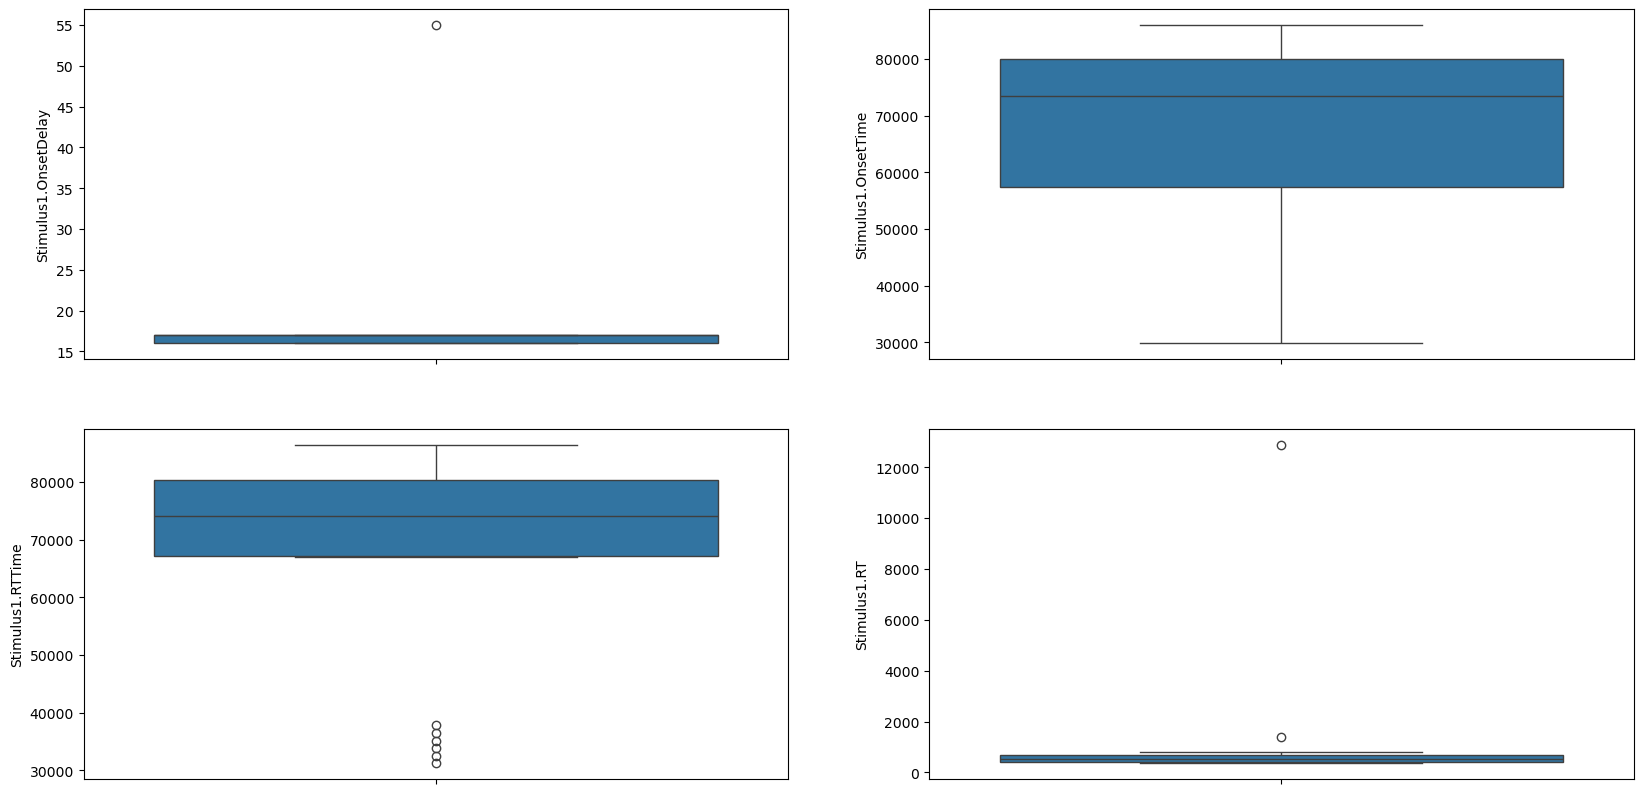

In [6]:
fig, axes = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(20)

# [[1,2], [3,4]].flatten() -> [1,2,3,4]
# zip((1,2,3,4), [A,B,C,D]) -> (1,A,) (2,B), (3,C)....
for ax, col in zip(axes.flatten(), ['OnsetDelay','OnsetTime','RTTime', 'RT']):
    sns.boxplot(data=df, y='Stimulus1.'+col, ax=ax)

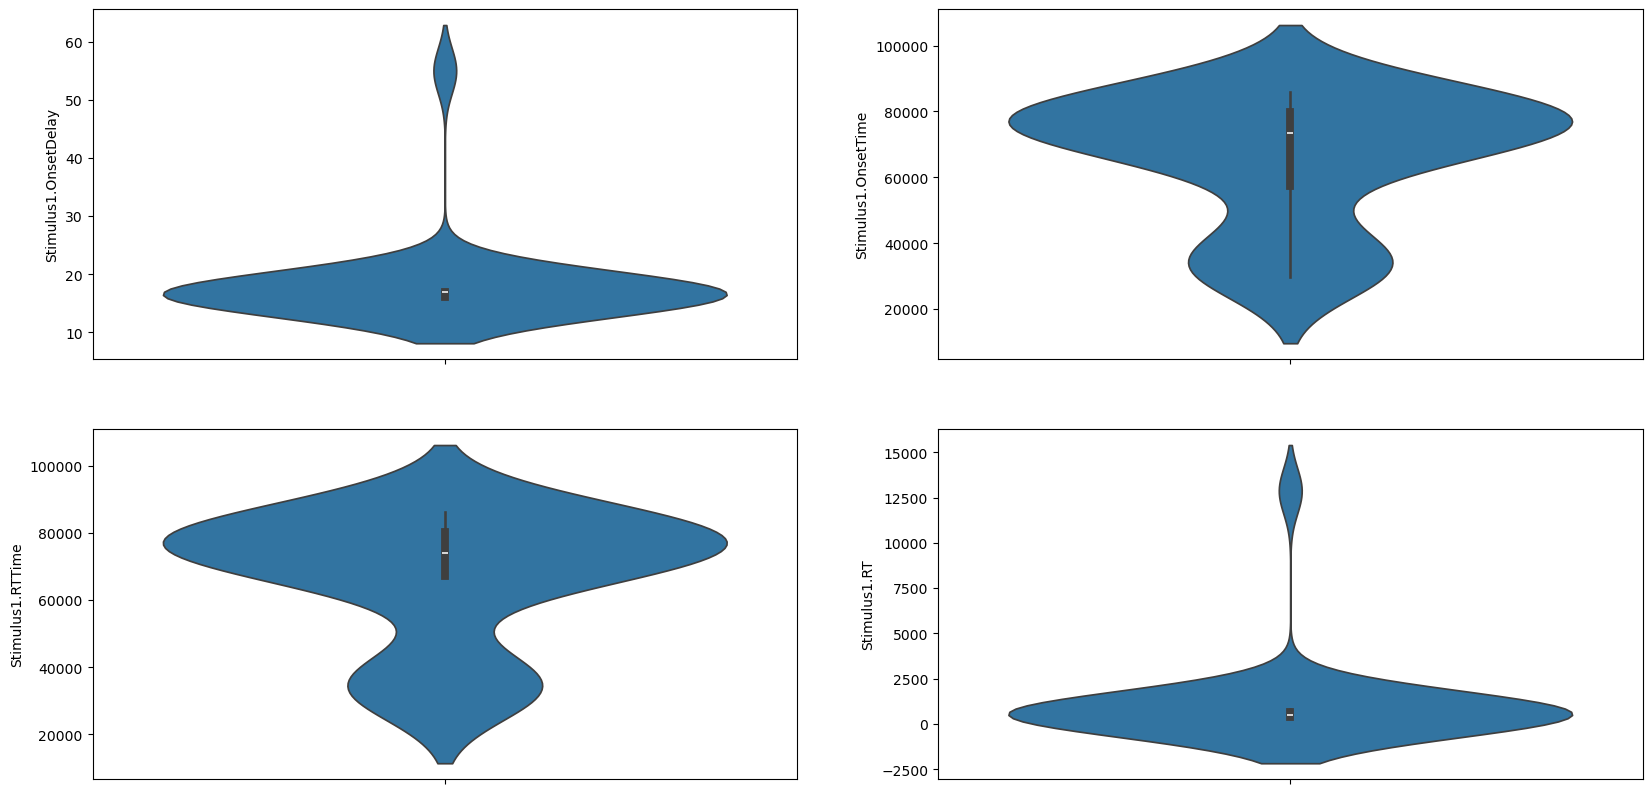

In [7]:
# for fun let's do vilin plot at the same time.
fig2, axes2 = plt.subplots(2,2)
fig2.set_figheight(10)
fig2.set_figwidth(20)

for ax2, col in zip(axes2.flatten(), ['OnsetDelay','OnsetTime','RTTime', 'RT']):
    sns.violinplot(data=df, y='Stimulus1.'+col, ax=ax2)